> Required Imports

In [1]:
import librosa
import librosa.display
import numpy as np
import pandas as pd
from os.path import exists, getsize
from IPython.display import Audio
from random import choice
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from config import CONFIG

import warnings
warnings.filterwarnings('ignore')

> Check for the smallest audio file and trim silence from the ends to capture the smallest audio length

In [2]:
df = pd.read_csv(CONFIG.get("files", "base_data"))

smallest_file = min(df["filepath"], key=getsize)
y, sr = librosa.load(smallest_file)
y, _ = librosa.effects.trim(y)
duration = librosa.get_duration(y=y, sr=sr)
display(duration)

filepath = choice(df["filepath"])

3.960090702947846

> Visualize the spectrogram and play the audio of a random sample from the training data

(128, 171)

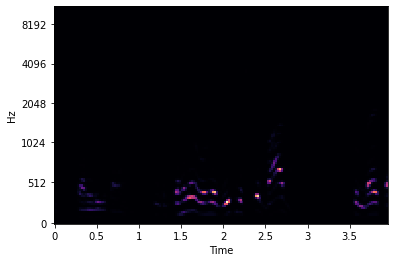

In [3]:
y, sr = librosa.load(filepath)
y, _ = librosa.effects.trim(y)

# Cut audio to a common denominator
y = y[:int(sr*duration)]
ps = librosa.feature.melspectrogram(y=y, sr=sr)
display(ps.shape)
librosa.display.specshow(ps, y_axis='mel', x_axis='time')
Audio(data=y, rate=sr)

> Function to create a spectrogram image from a given audio filepath

In [4]:
def create_image(filepath):
    y, sr = librosa.load(filepath)
    ynew, _ = librosa.effects.trim(y)
    if len(ynew) < int(sr*duration):
        y = y[:int(sr*duration)]
    else:
        y = ynew[:int(sr*duration)]
    ps = librosa.feature.melspectrogram(y=y, sr=sr)
    return ps
    
create_image(filepath).shape

(128, 171)

> Create Spectrograms for the whole dataset, and save as a pickle, or read previously pickled file

In [5]:
savepath = CONFIG.get("files", "base_data_spectro")

if exists(savepath):
    df = pd.read_pickle(savepath)
else:
    df["ps"] = df["filepath"].map(create_image)
    df.to_pickle(savepath)

> Format speaker_id as an integer

In [6]:
dataset = df[["speaker_id", "ps"]]
dataset["speaker_id"] = dataset["speaker_id"].str[2:].astype(int)
dataset.head()

,speaker_id,ps
0,10000,"[[0.0051502828, 0.005539708, 0.013680633, 0.07..."
1,10000,"[[0.006160707, 0.0072584287, 0.06725639, 0.250..."
2,10000,"[[0.005288213, 0.0061552343, 0.009574708, 0.04..."
3,10000,"[[0.007232231, 0.007873862, 0.006506714, 0.053..."
4,10000,"[[0.0056619, 0.0067198602, 0.009038991, 0.0579..."


> Split the dataset into training and test and stratify the split on the classes

In [7]:
X_train, X_test, y_train, y_test = train_test_split(dataset[["ps"]], dataset[["speaker_id"]], test_size=0.25, shuffle=True, stratify=dataset[["speaker_id"]])

> Convert the dataframe to CNN compatible formats

In [8]:
X_train = X_train["ps"].to_list()
X_test = X_test["ps"].to_list()
y_train = y_train["speaker_id"].to_list()
y_test = y_test["speaker_id"].to_list()

# Reshape for CNN input
X_train = np.array([x.reshape( (128, 171, 1) ) for x in X_train])
X_test = np.array([x.reshape( (128, 171, 1) ) for x in X_test])

code = np.array(y_train)
label_encoder = LabelEncoder()
vec = label_encoder.fit_transform(code)
y_train = to_categorical(vec)

vec = label_encoder.transform(y_test)
y_test = to_categorical(vec)

> Save the Train and Test data for training

In [9]:
with open(CONFIG.get("files", "train_test_data"), "wb") as f:
    np.save(f, X_train)
    np.save(f, y_train)
    np.save(f, X_test)
    np.save(f, y_test)